In [2]:
import numpy as np
from matplotlib import pyplot as plt

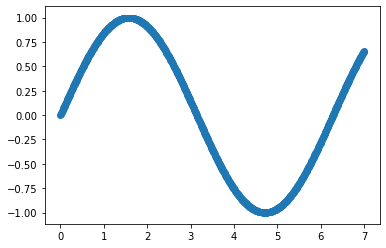

In [3]:
x = np.linspace(0, 7, 1000)
y = np.sin(x)
data = list(zip(x, y))
plt.scatter(x, y)

In [4]:
def slope(p1, p2):
    x1, y1 = p1
    x2, y2 = p2
    return (y2 - y1) / (x2 - x1)

# a x + b = y
# ax + b - y = 0
# ax - y = -b

def line(p1, p2):
    a = slope(p1, p2)
    b = -a * p1[0] + p1[1]
    return (a,b)

def intersection(l1, l2):
    a, c = l1
    b, d = l2
    
    return ((d - c) / (a - b)), ((a*d - b*c)/(a - b))

def above(pt, line):
    return pt[1] > line[0] * pt[0] + line[1]

def below(pt, line):
        return pt[1] < line[0] * pt[0] + line[1]

def upper_bound(pt, gamma):
    return (pt[0], pt[1] + gamma)

def lower_bound(pt, gamma):
    return (pt[0], pt[1] - gamma)

In [5]:
class GreedyPLR:
    def __init__(self, gamma):
        self.__state = "need2"
        self.__gamma = gamma
        
    def process(self, pt):
        self.__last_pt = pt
        if self.__state == "need2":
            self.__s0 = pt
            self.__state = "need1"
        elif self.__state == "need1":
            self.__s1 = pt
            self.__setup()
            self.__state = "ready"
        elif self.__state == "ready":
            return self.__process(pt)
        else:
            assert False
    
    def __setup(self):
        self.__rho_lower = line(upper_bound(self.__s0, self.__gamma),
                                lower_bound(self.__s1, self.__gamma))
        self.__rho_upper = line(lower_bound(self.__s0, self.__gamma),
                                upper_bound(self.__s1, self.__gamma))
        
        self.__sint = intersection(self.__rho_lower, self.__rho_upper)
        
    def __current_segment(self):
        segment_start = self.__s0[0]
        segment_stop = self.__last_pt[0]
        avg_slope = (self.__rho_lower[0] + self.__rho_upper[0]) / 2
        intercept = -avg_slope * self.__sint[0] + self.__sint[1]
        return (segment_start, segment_stop, avg_slope, intercept)
        
    def __process(self, pt):
        if not (above(pt, self.__rho_lower) and below(pt, self.__rho_upper)):
            # we have to start a new segment.
            prev_segment = self.__current_segment()
            
            self.__s0 = pt
            self.__state = "need1"
            
            # return the previous segment
            return prev_segment
        
        # we can tweak our extreme slopes to account for this point.
        # if this point's upper bound is below the current rho_upper,
        # we have to change rho_upper.

        s_upper = upper_bound(pt, self.__gamma)
        s_lower = lower_bound(pt, self.__gamma)
        if below(s_upper, self.__rho_upper):
            self.__rho_upper = line(self.__sint, s_upper)
        
        # if this point's lower bound is above the current rho_lower,
        # we have to change rho_lower
        if above(s_lower, self.__rho_lower):
            self.__rho_lower = line(self.__sint, s_lower)
            
        return None
    
    def finish(self):
        if self.__state == "need2":
            self.__state = "finished"
            return None
        elif self.__state == "need1":
            self.__state = "finished"
            return (self.__s0[0], self.__s0[0] + 1, 0, self.__s0[1])
        elif self.__state == "ready":
            self.__state = "finished"
            return self.__current_segment()
        else:
            assert False
        

In [6]:
plr = GreedyPLR(0.0005)
lines = []
for pt in data:
    l = plr.process(pt)
    if l:
        lines.append(l)
    
last = plr.finish()
if last:
    lines.append(last)
    
len(lines)

77

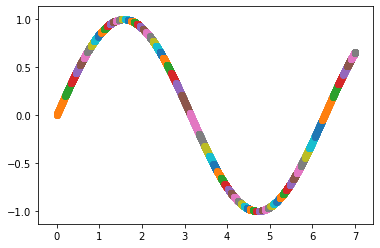

In [7]:
plt.scatter(x, y)
for l in lines:
    xl = np.linspace(l[0], l[1], 100)
    yl = l[2] * xl + l[3]
    plt.scatter(xl, yl)

In [8]:
def update_hull(hull, upper=True):
    # update an upper or lower convex hull using the triangle update rule
    # assume the hull is sorted by x coordinate already.
    
    # take the last three points of the hull. If the middle point is
    # above the line connecting the other two points, remove it. If not,
    # repeat. When updating the lower hull, check if below the line.
    reversed_hull = list(reversed(hull))
    kept_points = []
    while True:
        if len(reversed_hull) < 3:
            break
            
        pt1, pt2, pt3, *_ = reversed_hull
                
        l = line(pt1, pt3)
        if upper and above(pt2, l):
            del reversed_hull[1]
            continue
            
        if not upper and below(pt2, l):
            del reversed_hull[1]
            continue
            
        # otherwise, pt1 gets to stay!
        kept_points.insert(0, reversed_hull.pop(0))
        
        
    while reversed_hull:
        kept_points.insert(0, reversed_hull.pop(0))

    return kept_points

current_hull = [(1, 1), (2, 1), (3, 3), (4, 3)]
current_hull = update_hull(current_hull, upper=False)
current_hull

[(1, 1), (3, 3), (4, 3)]

In [9]:
def argmax(l):
    return max(enumerate(l), key=lambda x: x[1])[0]

def argmin(l):
    return min(enumerate(l), key=lambda x: x[1])[0]
        

class OptimalPLR:
    def __init__(self, gamma):
        self.__state = "need2"
        self.__gamma = gamma
        
    def process(self, pt):
        self.__last_pt = pt
        if self.__state == "need2":
            self.__s0 = pt
            self.__state = "need1"
        elif self.__state == "need1":
            self.__s1 = pt
            self.__setup()
            self.__state = "ready"
        elif self.__state == "ready":
            return self.__process(pt)
        else:
            assert False
    
    def __setup(self):
        self.__rho_lower = line(upper_bound(self.__s0, self.__gamma),
                                lower_bound(self.__s1, self.__gamma))
        self.__rho_upper = line(lower_bound(self.__s0, self.__gamma),
                                upper_bound(self.__s1, self.__gamma))
        
        self.__upper_hull = [upper_bound(self.__s0, self.__gamma),
                             upper_bound(self.__s1, self.__gamma)]
        self.__lower_hull = [lower_bound(self.__s0, self.__gamma),
                             lower_bound(self.__s1, self.__gamma)]
    def __current_segment(self):
        sint = intersection(self.__rho_lower, self.__rho_upper)
        segment_start = self.__s0[0]
        segment_stop = self.__last_pt[0]
        avg_slope = (self.__rho_lower[0] + self.__rho_upper[0]) / 2
        intercept = -avg_slope * sint[0] + sint[1]
        return (segment_start, segment_stop, avg_slope, intercept)
        
    def __process(self, pt):
        if not (above(pt, self.__rho_lower) and below(pt, self.__rho_upper)):
            # we have to start a new segment.
            prev_segment = self.__current_segment()
            
            self.__s0 = pt
            self.__state = "need1"
            
            # return the previous segment
            return prev_segment
        
        # we can tweak our extreme slopes to account for this point.
        # if this point's upper bound is below the current rho_upper,
        # we have to change rho_upper.

        s_upper = upper_bound(pt, self.__gamma)
        s_lower = lower_bound(pt, self.__gamma)
        if below(s_upper, self.__rho_upper):
            # find the point in the lower hull that would minimize
            # the slope between that point and s_upper. 
            resulting_slopes = [line(x, s_upper)[0] for x in self.__lower_hull]
            idx = argmin(resulting_slopes)
            self.__rho_upper = line(self.__lower_hull[idx], s_upper)
            
            # remove everything from the hull prior to that point, add new point
            self.__lower_hull = self.__lower_hull[idx:]
            self.__lower_hull.append(s_lower)
            self.__lower_hull = update_hull(self.__lower_hull, upper=False)

        
        # if this point's lower bound is above the current rho_lower,
        # we have to change rho_lower
        if above(s_lower, self.__rho_lower):
            # find the point in the upper hull that would maximize
            # the slope between the point and s_lower
            resulting_slopes = [line(x, s_lower)[0] for x in self.__upper_hull]
            idx = argmax(resulting_slopes)
            self.__rho_lower = line(self.__upper_hull[idx], s_lower)
            
            # remove everything from the hull prior to that point, add new point
            self.__upper_hull = self.__upper_hull[idx:]
            self.__upper_hull.append(s_upper)
            self.__upper_hull = update_hull(self.__upper_hull)
        
        return None
    
    def finish(self):
        if self.__state == "need2":
            self.__state = "finished"
            return None
        elif self.__state == "need1":
            self.__state = "finished"
            return (self.__s0[0], self.__s0[0] + 1, 0, self.__s0[1])
        elif self.__state == "ready":
            self.__state = "finished"
            return self.__current_segment()
        else:
            assert False

In [10]:
plr = OptimalPLR(0.25)
lines = []
for pt in data:
    l = plr.process(pt)
    if l:
        lines.append(l)
    
last = plr.finish()
if last:
    lines.append(last)
len(lines)

3

In [11]:
plr = OptimalPLR(0.025)
lines2 = []
for pt in data:
    l = plr.process(pt)
    if l:
        lines2.append(l)
    
last = plr.finish()
if last:
    lines2.append(last)
len(lines2)

9

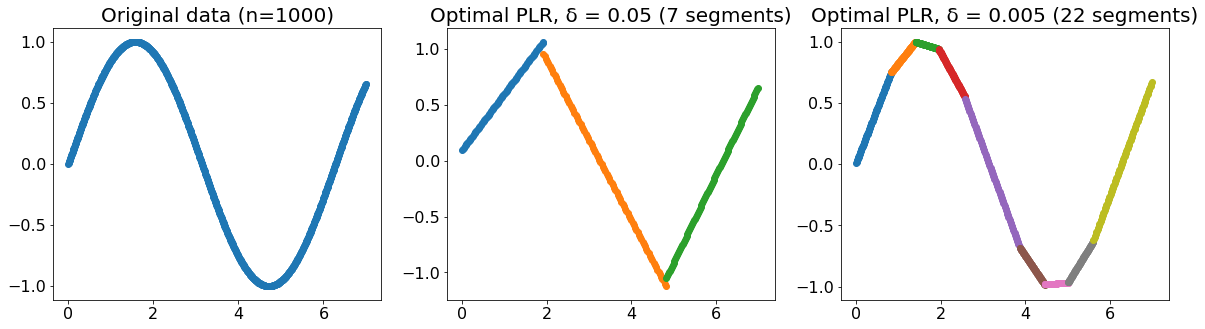

In [12]:
plt.figure(figsize=(20,5))


plt.subplot(1, 3, 1)
plt.scatter(x, y)
plt.title("Original data (n=1000)", size=20)
plt.tick_params(axis='x', labelrotation=0, labelsize=16)
plt.tick_params(axis='y', labelsize=16)

plt.subplot(1, 3, 2)
for l in lines:
    xl = np.linspace(l[0], l[1], 100)
    yl = l[2] * xl + l[3]
    plt.scatter(xl, yl)
plt.title("Optimal PLR, δ = 0.05 (7 segments)", size=20)
plt.tick_params(axis='x', labelrotation=0, labelsize=16)
plt.tick_params(axis='y', labelsize=16)
    
plt.subplot(1, 3, 3)
for l in lines2:
    xl = np.linspace(l[0], l[1], 100)
    yl = l[2] * xl + l[3]
    plt.scatter(xl, yl)
plt.title("Optimal PLR, δ = 0.005 (22 segments)", size=20)
plt.tick_params(axis='x', labelrotation=0, labelsize=16)
plt.tick_params(axis='y', labelsize=16)
plt.savefig("plot.png")


In [13]:
from_rust = [
(0, 0.224, 0.9925214438051018, 0.00014488723457774244),
(0.224, 0.371, 0.9564359979470114, 0.00811544111468232),
(0.371, 0.49000000000000005, 0.9098257927831952, 0.025184110625250444),
(0.49000000000000005, 0.602, 0.8560902362553744, 0.051374096095132604),
(0.602, 0.7000000000000001, 0.7973679477778012, 0.08644199332413038),
(0.7000000000000001, 0.798, 0.7345403303455742, 0.13026493807044426),
(0.798, 0.889, 0.6672938613391461, 0.18364968490552003),
(0.889, 0.9800000000000001, 0.5968809282166496, 0.2460461759022603),
(0.9800000000000001, 1.064, 0.52453963029918, 0.3166206305259157),
(1.064, 1.1480000000000001, 0.4512773049507166, 0.3943392750949695),
(1.1480000000000001, 1.232, 0.37483263881525447, 0.48185046990923225),
(1.232, 1.316, 0.2957447083682151, 0.5790264497986415),
(1.316, 1.4000000000000001, 0.21456509612801, 0.6855881183987156),
(1.4000000000000001, 1.4769999999999999, 0.13535613338353905, 0.7961030925848586),
(1.4769999999999999, 1.554, 0.05875237893886226, 0.9089827857523513),
(1.554, 1.631, -0.018199546284158596, 1.0282975942267096),
(1.631, 1.708, -0.09504361970083763, 1.153358954523449),
(1.708, 1.792, -0.17476140876329194, 1.2893415834624926),
(1.792, 1.8760000000000001, -0.25674332111792314, 1.4359537229597428),
(1.8760000000000001, 1.9600000000000002, -0.3369097215772785, 1.5860507383639242),
(1.9600000000000002, 2.044, -0.41470028452663665, 1.7382295287324734),
(2.044, 2.128, -0.4895664424253739, 1.890971731375827),
(2.128, 2.219, -0.5638422878887794, 2.0488442399382443),
(2.219, 2.31, -0.6365330755574079, 2.20984715465532),
(2.31, 2.408, -0.7064150208952986, 2.371076767650351),
(2.408, 2.506, -0.7722395133713664, 2.529290458375451),
(2.506, 2.6109999999999998, -0.832566340878024, 2.680265889786253),
(2.6109999999999998, 2.73, -0.8890772083181679, 2.827667324426729),
(2.73, 2.863, -0.9393402024298271, 2.9646838555034947),
(2.863, 3.045, -0.980719181256966, 3.0830673326267295),
(3.045, 3.346, -1.0587004536456222, 3.3386367109432715),
(3.346, 3.5, -1.0194089527822754, 3.2163564540974594),
(3.5, 3.6260000000000003, -0.969537899233178, 3.0490937912774494),
(3.6260000000000003, 3.745, -0.9112648557380234, 2.8443939825940068),
(3.745, 3.8500000000000005, -0.8470640051072593, 2.6097982889007594),
(3.8500000000000005, 3.9549999999999996, -0.7778436510635867, 2.3488828625107105),
(3.9549999999999996, 4.053, -0.7035404258383973, 2.0602635640493663),
(4.053, 4.151, -0.6255241060600776, 1.7491566288953644),
(4.151, 4.242, -0.5452012677617251, 1.420545750946877),
(4.242, 4.333, -0.4637127145158647, 1.0795392357639941),
(4.333, 4.424, -0.3788934556974868, 0.7166593459207461),
(4.424, 4.515000000000001, -0.29144539501621314, 0.3344128066449319),
(4.515000000000001, 4.606, -0.20211904114644377, -0.06428224649977465),
(4.606, 4.69, -0.1151167858286416, -0.4606319398756733),
(4.69, 4.774, -0.031174188126666322, -0.8500583320514762),
(4.774, 4.858, 0.05256849223960554, -1.2455724883595696),
(4.858, 4.949, 0.13893433546476147, -1.6606130712268432),
(4.949, 5.04, 0.2271286146332705, -2.092412737173717),
(5.04, 5.131, 0.3129166735955567, -2.520077948156951),
(5.131, 5.2219999999999995, 0.3956086070533476, -2.939622030057251),
(5.2219999999999995, 5.313, 0.4745201155249519, -3.346901263923985),
(5.313, 5.4110000000000005, 0.5517095003597423, -3.751884706679768),
(5.4110000000000005, 5.509, 0.6260229407482628, -4.148680392368301),
(5.509, 5.614000000000001, 0.6958450294401022, -4.527636690886439),
(5.614000000000001, 5.726, 0.761797755685506, -4.891664002832056),
(5.726, 5.845, 0.8211801307009096, -5.224864212667721),
(5.845, 5.984999999999999, 0.873255945628706, -5.52102481985113),
(5.984999999999999, 6.167, 0.9148761058720644, -5.758745208484667),
(6.167, 6.503, 0.9929896535897769, -6.239043539927865),
(6.503, 6.6499999999999995, 0.9576396162376866, -6.009263861693788),
(6.6499999999999995, 6.769, 0.9115503947797831, -5.702988862860086),
(6.769, 6.881, 0.8582426830616655, -5.342287319093105),
(6.881, 6.986, 0.7977272612145305, -4.926080687706908),
(6.986, 6.993, 0.7607573751780505, -4.6682830946896905)
]

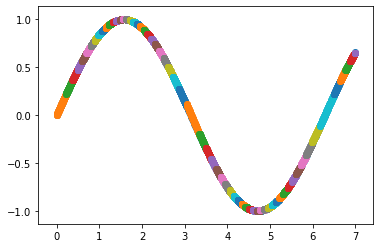

In [14]:
plt.scatter(x, y)
for l in from_rust:
    xl = np.linspace(l[0], l[1], 100)
    yl = l[2] * xl + l[3]
    plt.scatter(xl, yl)